In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.ticker
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.neighbors
import scipy.stats
import random
import math
import itertools

%matplotlib inline
plt.rcParams['figure.figsize'] = (11.0, 11.0) # set default size of plots/

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Display numbers more compactly
np.set_printoptions(precision=3)
pd.set_option("display.precision", 3)
# When to wrap numpy output
np.set_printoptions(linewidth=200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generate the data using the algorithm (oracle) described on page 16:

In [35]:
# Make random numbers predictable, change this to 'rerun' the simulation
np.random.seed(0)
random.seed(0)    # we also use python's random module for convencience

means_per_class = 10
blue_means   = np.random.multivariate_normal(mean=[0,1], cov=np.identity(2), size=means_per_class)
orange_means = np.random.multivariate_normal(mean=[1,0], cov=np.identity(2), size=means_per_class)
xlimits = [-3, 4]
ylimits = [-3, 4]

def generate_point(means, covariance):
    """
    Return a sample from 2d random gaussian, with covariance `covariance` and
    mean randomly selected from `means`.
    """
    mean = random.choice(means)
    return np.random.multivariate_normal(mean=mean, cov=covariance)

points_per_class = 100
point_variance = 1/5
point_covariance_matrix = np.identity(2) * point_variance
blue_points   = np.array([generate_point(blue_means, point_covariance_matrix) for i in range(points_per_class)])
orange_points = np.array([generate_point(orange_means, point_covariance_matrix) for i in range(points_per_class)])
X = np.r_[blue_points, orange_points]
y = np.r_[np.zeros(points_per_class), np.ones(points_per_class)]

Train and plot linear model:

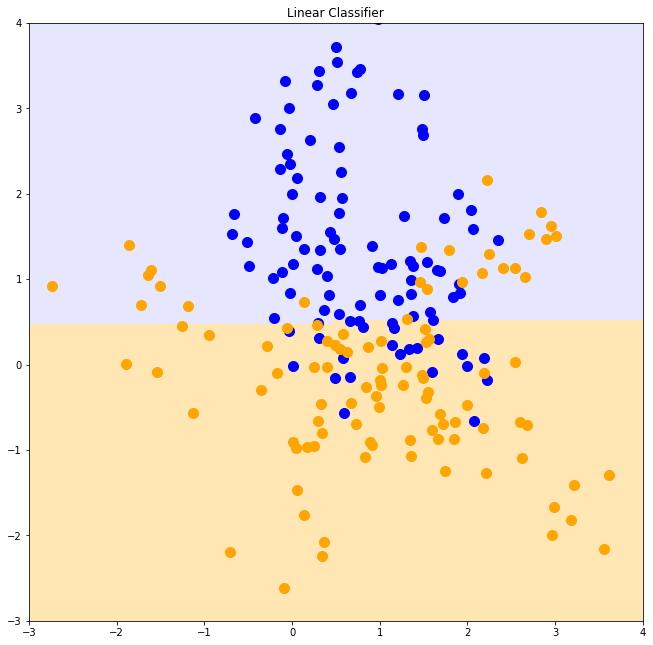

In [36]:
def train_linear(X, y):
    linear_classifier = sklearn.linear_model.LinearRegression()
    linear_classifier.fit(X, y)
    return linear_classifier

# Referenced https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib
def plot_decision_regions(classifier, axes, xlimits, ylimits):
    horizontal = np.linspace(xlimits[0], xlimits[1], 150)
    vertical   = np.linspace(ylimits[0], ylimits[1], 150)
    h, v = np.meshgrid(horizontal, vertical)
    points = np.c_[h.ravel(), v.ravel()]
    results = classifier.predict(points)
    results = results.reshape(h.shape)
    cmap = matplotlib.colors.ListedColormap([(0.9, 0.9, 1), (1, 0.9, 0.7)])
    axes.pcolormesh(h, v, results, cmap=cmap)
    
def plot_points(axes):
    axes.scatter(x=blue_points[:,0], y=blue_points[:,1], color="blue", marker='o', s=100)
    axes.scatter(x=orange_points[:,0], y=orange_points[:,1], color="orange", marker='o', s=100)

def plot_classifier(axes, classifier, xlimits, ylimits):
    axes.set_xlim(xlimits)
    axes.set_ylim(ylimits)

    plot_decision_regions(classifier, axes, xlimits, ylimits)
    plot_points(axes)
    return axes

fig, axes = plt.subplots(1, 1)
linear_classifier = train_linear(X, y)
axes = plot_classifier(axes, linear_classifier, xlimits, ylimits)
_ = axes.set_title("Linear Classifier")

Train and plot k-nearest neighbor models:

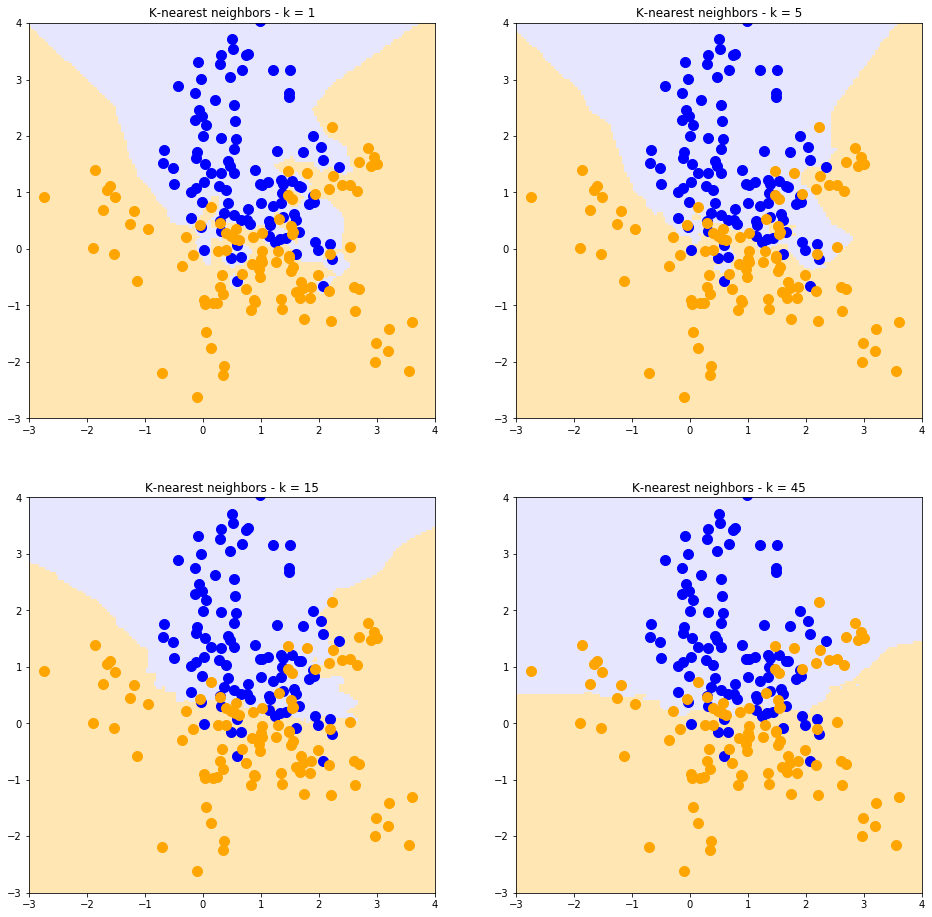

In [37]:
def train_knn(X, y, k):
    knn_classifier = sklearn.neighbors.KNeighborsClassifier(k, weights='uniform')
    knn_classifier.fit(X, y)
    return knn_classifier

ks = [1, 5, 15, 45]
fig, axes_matrix = plt.subplots(2, 2, figsize=(16.0, 16.0))
axes_seq = itertools.chain.from_iterable(axes_matrix)
for k, axes in zip(ks, axes_seq):
    knn_classifier = train_knn(X, y, k)
    plot_classifier(axes, knn_classifier, xlimits, ylimits)
    axes.set_title(f"K-nearest neighbors - k = {k}")

'Train' a Bayes optimal classifier using the true distribution of the data.

TODO: insert explanation of calculating likelihood.

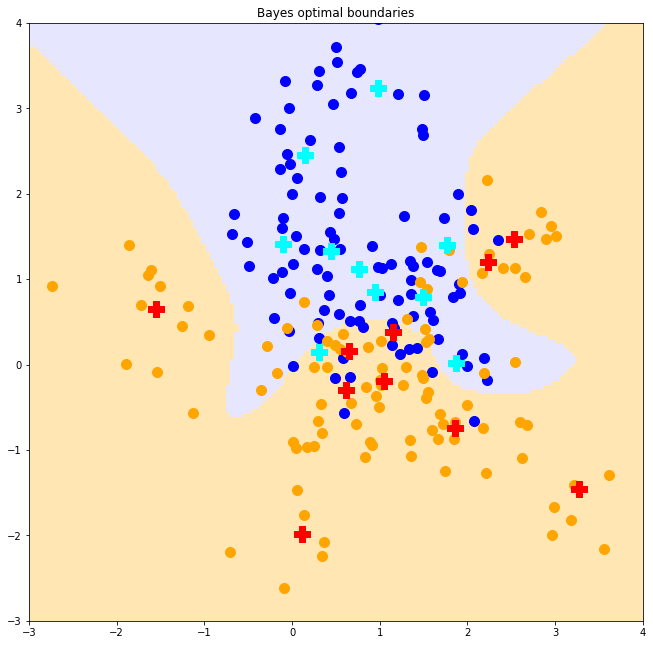

In [38]:
X_means = np.r_[blue_means, orange_means]
y_means = np.r_[np.zeros(means_per_class), np.ones(means_per_class)]

point_std = math.sqrt(point_variance)
def train_knn_gaussian_kernel(X, y, k):
    knn_classifier = sklearn.neighbors.KNeighborsClassifier(k, weights=lambda arr: scipy.stats.norm.pdf(arr, scale=point_std))
    knn_classifier.fit(X, y)
    return knn_classifier

def plot_means(axes):
    axes.scatter(x=blue_means[:,0], y=blue_means[:,1], color="cyan", marker='P', s=250)
    axes.scatter(x=orange_means[:,0], y=orange_means[:,1], color="red", marker='P', s=250)

# Use all points (weighted by their distances with a gaussian kernel)
k = 2 * means_per_class
fig, axes = plt.subplots(1, 1)
bayes_optimal_classifier = train_knn_gaussian_kernel(X_means, y_means, k)
plot_classifier(axes, bayes_optimal_classifier, xlimits, ylimits)
plot_means(axes)
_ = axes.set_title("Bayes optimal boundaries")

Misclassification curves

In [39]:
# technically we shouldn't mandate that the test data be exactly 50% split
# between the classes, but it's okay to make that simplification for this example.
test_samples_per_class = 5000

blue_test_points   = np.array([generate_point(blue_means, point_covariance_matrix)
                               for i in range(test_samples_per_class)])
orange_test_points = np.array([generate_point(orange_means, point_covariance_matrix)
                               for i in range(test_samples_per_class)])
Xte = np.r_[blue_test_points, orange_test_points]
yte = np.r_[np.zeros(test_samples_per_class), np.ones(test_samples_per_class)]

In [40]:
ks = [199, 151, 123, 101, 81, 67, 55, 45, 37, 31, 27, 23, 19, 15, 11, 9, 7, 5, 3, 1]
knn_test_errors  = [1 - train_knn(X, y, k).score(Xte, yte) for k in ks]
knn_train_errors = [1 - train_knn(X, y, k).score(X, y) for k in ks]

linear_classifier = train_linear(X, y)
linear_test_error  = 1 - ((linear_classifier.predict(Xte) > 0.5) == (yte > 0.5)).mean()
linear_train_error = 1 - ((linear_classifier.predict(X) > 0.5) == (y > 0.5)).mean()

bayes_error_rate = 1 - bayes_optimal_classifier.score(Xte, yte)

k with lowest validation error: 11


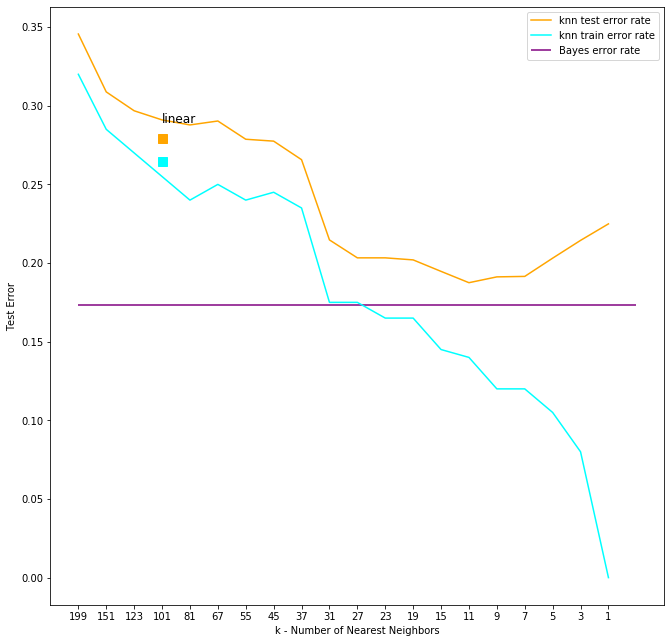

In [41]:
fig, axes = plt.subplots(1, 1)
ticks = list(range(0, len(ks)))
axes.plot(ticks, knn_test_errors, color='orange', label='knn test error rate')
axes.plot(ticks, knn_train_errors, color='cyan', label='knn train error rate')
axes.xaxis.set_ticks(ticks) # set the tick spacing
axes.xaxis.set_ticklabels(ks)
axes.set_xlabel("k - Number of Nearest Neighbors")
axes.set_ylabel("Test Error")

# Hardcoding the horizontal location of the linear points for now.
axes.text(3, linear_test_error + 0.01, 'linear', fontsize=12)
axes.plot(3, linear_test_error,  color='orange', marker='s', markersize=9)
axes.plot(3, linear_train_error, color='cyan', marker='s', markersize=9)

axes.hlines(bayes_error_rate, 0, len(ks), color='purple', label='Bayes error rate')

axes.legend()

k_with_min_error = ks[knn_test_errors.index(min(knn_test_errors))]
print(f"k with lowest validation error: {k_with_min_error}")

Increasing the amount of training data gives smoother error curves, and leads to a larger value of k being selected (to reduce variance).
The `points_per_class` variable controls the amount of training data.